# Bining

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,load_model
from keras import layers

from sklearn.model_selection import train_test_split,StratifiedKFold
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

2024-08-26 13:58:55.418082: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 13:58:55.463265: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 13:58:55.464616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 13:58:56.484405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
state0_init = np.load('/pscratch/sd/n/nrvora/Data/Quantum/longterm/dlo_state0.npy')
state1_init = np.load('/pscratch/sd/n/nrvora/Data/Quantum/longterm/dlo_state1.npy')
state2_init = np.load('/pscratch/sd/n/nrvora/Data/Quantum/longterm/dlo_state2.npy')

In [3]:
start = [1100,1100,1300,1300]
end = [2500,2300,2500,2300]
time_dict={}
for  t in zip(start,end):
    print(f'running for {t[0]} to {t[1]}')
    state0 = state0_init[:,t[0]:t[1]]
    state1 = state1_init[:,t[0]:t[1]]
    state2 = state2_init[:,t[0]:t[1]]
    output0=np.zeros((state0.shape[0]))
    output1=np.ones((state1.shape[0]))
    output2=np.array((2,)*state2.shape[0])
    trainData = np.vstack((state0,state1,state2))
    trainLabel = np.hstack((output0,output1,output2))

    X_init=np.stack((trainData.real,trainData.imag))
    y_init=trainLabel.reshape(-1)
    bins=[1,2,4,8,16,32,64,128,256]
    bin_dict={}
    for k in bins:
        print(f'For bin {k}')
        size_bin=k
        nums_bin = X_init.shape[2]//size_bin
        binI,binQ=[],[]
        for i in range(nums_bin):
            st=i*size_bin
            ed=st+size_bin
            binI.append(np.mean(X_init[0,:,st:ed],axis=-1))
            binQ.append(np.mean(X_init[1,:,st:ed],axis=-1))
        binI=np.array(binI).T
        binQ=np.array(binQ).T
        X=np.hstack((binI,binQ))
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_standardized = (X - mean) / std

        X_standardized.shape
        y = to_categorical(y_init, num_classes=3)

        x_train, x_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.30, random_state=45)
        model = Sequential()
        model.add(layers.Input(shape=(x_train.shape[1],), name='Input_Layer'))
        model.add(layers.Dense(16, activation='relu', name='Hidden_Layer_1'))
        model.add(layers.Dense(3, activation='softmax', name='Output_Layer'))


        # Compile the model
        optimizer = tf.keras.optimizers.Adam()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

        model_path="model2/best.h5"
        checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        callbacks_list = [checkpoint]
        model.fit(x_train, y_train, epochs=100, batch_size=512, validation_split=0.2, 
          callbacks=callbacks_list,verbose=0
          )
        model = load_model('/global/homes/n/nrvora/Projects/Quantum/multi_state/model2/best.h5', compile=False)
        num_folds = 5
        skf = StratifiedKFold(n_splits=num_folds)
        accuracies = []
        conf_matrices = []

        for train_index, test_index in skf.split(x_test, np.argmax(y_test, axis=1)):
            x_train_fold, x_test_fold = x_test[train_index], x_test[test_index]
            y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]
            
            Y_pred_fold = model.predict(x_test_fold,verbose=0)
            Y_test_labels_fold = np.argmax(y_test_fold, axis=1)
            Y_pred_labels_fold = np.argmax(Y_pred_fold, axis=1)
            
            accuracy = accuracy_score(Y_test_labels_fold, Y_pred_labels_fold)
            accuracies.append(accuracy)
            
            conf_matrix_fold = confusion_matrix(Y_test_labels_fold, Y_pred_labels_fold)
            conf_matrices.append(conf_matrix_fold)

        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)

        # Print the mean accuracy with error bars
        bin_dict[k]=f'Test Accuracy: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%'
        print(f'Done bin {k}')
        print(bin_dict)
        # print(f'Test Accuracy: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%')
    index = f'{t[0]/2 - 350} - {t[1]/2 - 350}'
    time_dict[index]=bin_dict
    print(f'Done {t[0]} to {t[1]}')




running for 1100 to 2500
For bin 1


2024-08-26 13:59:24.145637: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 1
{1: 'Test Accuracy: 95.42% ± 0.41%'}
For bin 2


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 2
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%'}
For bin 4


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 4
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%', 4: 'Test Accuracy: 95.56% ± 0.33%'}
For bin 8


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 8
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%', 4: 'Test Accuracy: 95.56% ± 0.33%', 8: 'Test Accuracy: 95.83% ± 0.46%'}
For bin 16


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 16
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%', 4: 'Test Accuracy: 95.56% ± 0.33%', 8: 'Test Accuracy: 95.83% ± 0.46%', 16: 'Test Accuracy: 95.37% ± 0.40%'}
For bin 32


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 32
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%', 4: 'Test Accuracy: 95.56% ± 0.33%', 8: 'Test Accuracy: 95.83% ± 0.46%', 16: 'Test Accuracy: 95.37% ± 0.40%', 32: 'Test Accuracy: 95.77% ± 0.42%'}
For bin 64


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 64
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%', 4: 'Test Accuracy: 95.56% ± 0.33%', 8: 'Test Accuracy: 95.83% ± 0.46%', 16: 'Test Accuracy: 95.37% ± 0.40%', 32: 'Test Accuracy: 95.77% ± 0.42%', 64: 'Test Accuracy: 96.19% ± 0.35%'}
For bin 128


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 128
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%', 4: 'Test Accuracy: 95.56% ± 0.33%', 8: 'Test Accuracy: 95.83% ± 0.46%', 16: 'Test Accuracy: 95.37% ± 0.40%', 32: 'Test Accuracy: 95.77% ± 0.42%', 64: 'Test Accuracy: 96.19% ± 0.35%', 128: 'Test Accuracy: 95.95% ± 0.43%'}
For bin 256


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 256
{1: 'Test Accuracy: 95.42% ± 0.41%', 2: 'Test Accuracy: 95.21% ± 0.45%', 4: 'Test Accuracy: 95.56% ± 0.33%', 8: 'Test Accuracy: 95.83% ± 0.46%', 16: 'Test Accuracy: 95.37% ± 0.40%', 32: 'Test Accuracy: 95.77% ± 0.42%', 64: 'Test Accuracy: 96.19% ± 0.35%', 128: 'Test Accuracy: 95.95% ± 0.43%', 256: 'Test Accuracy: 95.90% ± 0.32%'}
Done 1100 to 2500
running for 1100 to 2300
For bin 1


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 1
{1: 'Test Accuracy: 95.13% ± 0.37%'}
For bin 2


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 2
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%'}
For bin 4


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 4
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%', 4: 'Test Accuracy: 95.03% ± 0.43%'}
For bin 8


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 8
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%', 4: 'Test Accuracy: 95.03% ± 0.43%', 8: 'Test Accuracy: 95.43% ± 0.40%'}
For bin 16


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 16
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%', 4: 'Test Accuracy: 95.03% ± 0.43%', 8: 'Test Accuracy: 95.43% ± 0.40%', 16: 'Test Accuracy: 95.37% ± 0.47%'}
For bin 32


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 32
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%', 4: 'Test Accuracy: 95.03% ± 0.43%', 8: 'Test Accuracy: 95.43% ± 0.40%', 16: 'Test Accuracy: 95.37% ± 0.47%', 32: 'Test Accuracy: 95.59% ± 0.42%'}
For bin 64


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 64
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%', 4: 'Test Accuracy: 95.03% ± 0.43%', 8: 'Test Accuracy: 95.43% ± 0.40%', 16: 'Test Accuracy: 95.37% ± 0.47%', 32: 'Test Accuracy: 95.59% ± 0.42%', 64: 'Test Accuracy: 95.40% ± 0.20%'}
For bin 128


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 128
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%', 4: 'Test Accuracy: 95.03% ± 0.43%', 8: 'Test Accuracy: 95.43% ± 0.40%', 16: 'Test Accuracy: 95.37% ± 0.47%', 32: 'Test Accuracy: 95.59% ± 0.42%', 64: 'Test Accuracy: 95.40% ± 0.20%', 128: 'Test Accuracy: 95.64% ± 0.26%'}
For bin 256


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 256
{1: 'Test Accuracy: 95.13% ± 0.37%', 2: 'Test Accuracy: 95.01% ± 0.30%', 4: 'Test Accuracy: 95.03% ± 0.43%', 8: 'Test Accuracy: 95.43% ± 0.40%', 16: 'Test Accuracy: 95.37% ± 0.47%', 32: 'Test Accuracy: 95.59% ± 0.42%', 64: 'Test Accuracy: 95.40% ± 0.20%', 128: 'Test Accuracy: 95.64% ± 0.26%', 256: 'Test Accuracy: 94.75% ± 0.32%'}
Done 1100 to 2300
running for 1300 to 2500
For bin 1


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 1
{1: 'Test Accuracy: 95.73% ± 0.36%'}
For bin 2


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 2
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%'}
For bin 4


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 4
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%', 4: 'Test Accuracy: 95.59% ± 0.27%'}
For bin 8


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 8
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%', 4: 'Test Accuracy: 95.59% ± 0.27%', 8: 'Test Accuracy: 95.64% ± 0.40%'}
For bin 16


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 16
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%', 4: 'Test Accuracy: 95.59% ± 0.27%', 8: 'Test Accuracy: 95.64% ± 0.40%', 16: 'Test Accuracy: 95.93% ± 0.35%'}
For bin 32


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 32
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%', 4: 'Test Accuracy: 95.59% ± 0.27%', 8: 'Test Accuracy: 95.64% ± 0.40%', 16: 'Test Accuracy: 95.93% ± 0.35%', 32: 'Test Accuracy: 96.04% ± 0.31%'}
For bin 64


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 64
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%', 4: 'Test Accuracy: 95.59% ± 0.27%', 8: 'Test Accuracy: 95.64% ± 0.40%', 16: 'Test Accuracy: 95.93% ± 0.35%', 32: 'Test Accuracy: 96.04% ± 0.31%', 64: 'Test Accuracy: 96.04% ± 0.30%'}
For bin 128


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 128
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%', 4: 'Test Accuracy: 95.59% ± 0.27%', 8: 'Test Accuracy: 95.64% ± 0.40%', 16: 'Test Accuracy: 95.93% ± 0.35%', 32: 'Test Accuracy: 96.04% ± 0.31%', 64: 'Test Accuracy: 96.04% ± 0.30%', 128: 'Test Accuracy: 96.07% ± 0.27%'}
For bin 256


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 256
{1: 'Test Accuracy: 95.73% ± 0.36%', 2: 'Test Accuracy: 95.23% ± 0.31%', 4: 'Test Accuracy: 95.59% ± 0.27%', 8: 'Test Accuracy: 95.64% ± 0.40%', 16: 'Test Accuracy: 95.93% ± 0.35%', 32: 'Test Accuracy: 96.04% ± 0.31%', 64: 'Test Accuracy: 96.04% ± 0.30%', 128: 'Test Accuracy: 96.07% ± 0.27%', 256: 'Test Accuracy: 95.70% ± 0.40%'}
Done 1300 to 2500
running for 1300 to 2300
For bin 1


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 1
{1: 'Test Accuracy: 94.97% ± 0.34%'}
For bin 2


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 2
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%'}
For bin 4


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 4
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%', 4: 'Test Accuracy: 94.87% ± 0.32%'}
For bin 8


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 8
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%', 4: 'Test Accuracy: 94.87% ± 0.32%', 8: 'Test Accuracy: 95.19% ± 0.36%'}
For bin 16


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 16
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%', 4: 'Test Accuracy: 94.87% ± 0.32%', 8: 'Test Accuracy: 95.19% ± 0.36%', 16: 'Test Accuracy: 95.56% ± 0.33%'}
For bin 32


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 32
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%', 4: 'Test Accuracy: 94.87% ± 0.32%', 8: 'Test Accuracy: 95.19% ± 0.36%', 16: 'Test Accuracy: 95.56% ± 0.33%', 32: 'Test Accuracy: 95.47% ± 0.32%'}
For bin 64


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 64
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%', 4: 'Test Accuracy: 94.87% ± 0.32%', 8: 'Test Accuracy: 95.19% ± 0.36%', 16: 'Test Accuracy: 95.56% ± 0.33%', 32: 'Test Accuracy: 95.47% ± 0.32%', 64: 'Test Accuracy: 95.47% ± 0.31%'}
For bin 128


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 128
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%', 4: 'Test Accuracy: 94.87% ± 0.32%', 8: 'Test Accuracy: 95.19% ± 0.36%', 16: 'Test Accuracy: 95.56% ± 0.33%', 32: 'Test Accuracy: 95.47% ± 0.32%', 64: 'Test Accuracy: 95.47% ± 0.31%', 128: 'Test Accuracy: 95.30% ± 0.29%'}
For bin 256


/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done bin 256
{1: 'Test Accuracy: 94.97% ± 0.34%', 2: 'Test Accuracy: 94.73% ± 0.43%', 4: 'Test Accuracy: 94.87% ± 0.32%', 8: 'Test Accuracy: 95.19% ± 0.36%', 16: 'Test Accuracy: 95.56% ± 0.33%', 32: 'Test Accuracy: 95.47% ± 0.32%', 64: 'Test Accuracy: 95.47% ± 0.31%', 128: 'Test Accuracy: 95.30% ± 0.29%', 256: 'Test Accuracy: 94.11% ± 0.39%'}
Done 1300 to 2300


In [4]:
import json

In [5]:
with open("20240826_exp2.json", "w") as outfile: 
    json.dump(time_dict, outfile)

In [6]:
time_dict

{'200.0 - 900.0': {1: 'Test Accuracy: 95.42% ± 0.41%',
  2: 'Test Accuracy: 95.21% ± 0.45%',
  4: 'Test Accuracy: 95.56% ± 0.33%',
  8: 'Test Accuracy: 95.83% ± 0.46%',
  16: 'Test Accuracy: 95.37% ± 0.40%',
  32: 'Test Accuracy: 95.77% ± 0.42%',
  64: 'Test Accuracy: 96.19% ± 0.35%',
  128: 'Test Accuracy: 95.95% ± 0.43%',
  256: 'Test Accuracy: 95.90% ± 0.32%'},
 '200.0 - 800.0': {1: 'Test Accuracy: 95.13% ± 0.37%',
  2: 'Test Accuracy: 95.01% ± 0.30%',
  4: 'Test Accuracy: 95.03% ± 0.43%',
  8: 'Test Accuracy: 95.43% ± 0.40%',
  16: 'Test Accuracy: 95.37% ± 0.47%',
  32: 'Test Accuracy: 95.59% ± 0.42%',
  64: 'Test Accuracy: 95.40% ± 0.20%',
  128: 'Test Accuracy: 95.64% ± 0.26%',
  256: 'Test Accuracy: 94.75% ± 0.32%'},
 '300.0 - 900.0': {1: 'Test Accuracy: 95.73% ± 0.36%',
  2: 'Test Accuracy: 95.23% ± 0.31%',
  4: 'Test Accuracy: 95.59% ± 0.27%',
  8: 'Test Accuracy: 95.64% ± 0.40%',
  16: 'Test Accuracy: 95.93% ± 0.35%',
  32: 'Test Accuracy: 96.04% ± 0.31%',
  64: 'Test Accurac

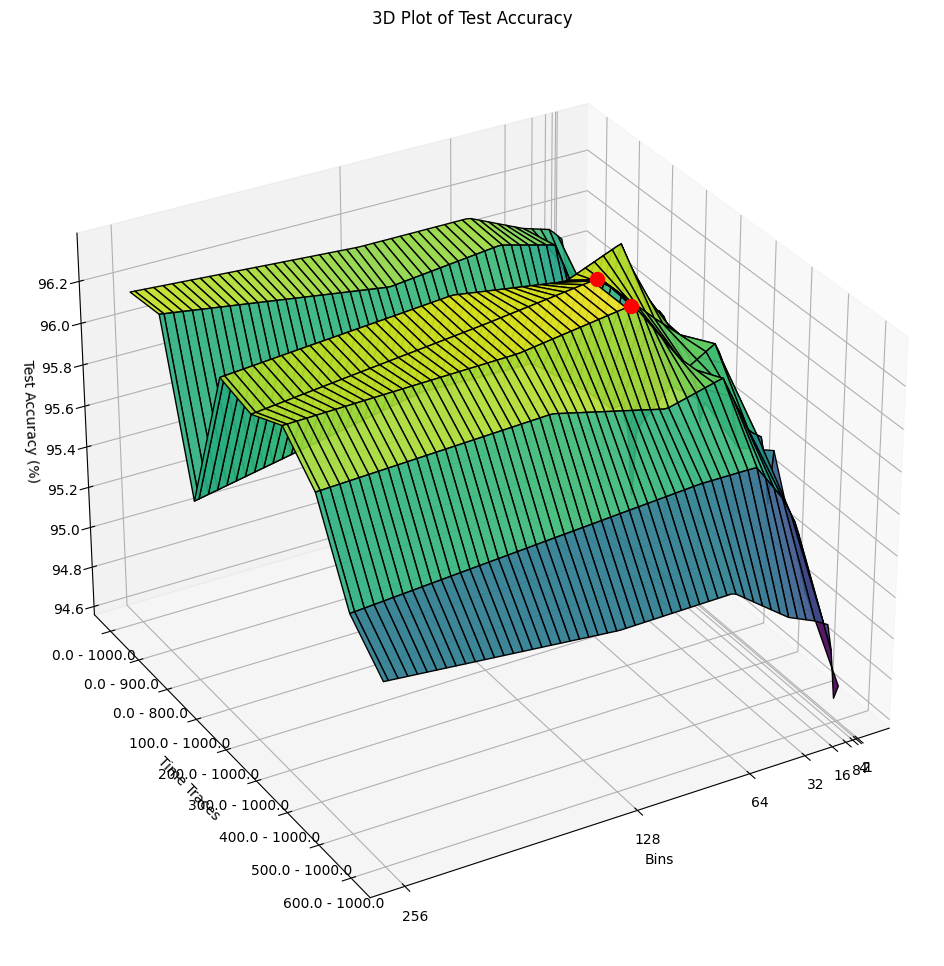

In [70]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the JSON data
file_path = '20240826_exp.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Prepare the data for plotting
time_traces = list(data.keys())
bins = sorted([int(bin_key) for bin_key in data[time_traces[0]].keys()])

# Create a DataFrame to hold the accuracies
accuracy_data = {trace: [] for trace in time_traces}
for trace in time_traces:
    for bin_key in bins:
        accuracy = data[trace][str(bin_key)].split(' ')[2].replace('%', '')
        accuracy_data[trace].append(float(accuracy))

df = pd.DataFrame(accuracy_data, index=bins)

# Remove specific columns
time_traces.remove("0.0 - 600.0")
time_traces.remove("0.0 - 700.0")

# Recreate X, Y, and Z with the updated time_traces
bins_fine = np.linspace(min(bins), max(bins), 100)
time_trace_indices = np.arange(len(time_traces))
X_fine, Y_fine = np.meshgrid(bins_fine, time_trace_indices)
Z_fine = np.zeros_like(X_fine)

# Interpolate Z values for a smoother surface after removing the columns
for i, trace in enumerate(time_traces):
    Z_fine[i] = np.interp(bins_fine, bins, accuracy_data[trace])

# Identify the two peaks (maximum accuracy points) in the dataset
max_accuracy_1 = np.max(Z_fine)
max_index_1 = np.unravel_index(np.argmax(Z_fine), Z_fine.shape)
max_bin_1 = bins_fine[max_index_1[1]]
max_time_trace_1 = time_traces[max_index_1[0]]

# Set the first peak value to a very low number to find the second peak
Z_fine[max_index_1] = -np.inf

# Find the second peak
max_accuracy_2 = np.max(Z_fine)
max_index_2 = np.unravel_index(np.argmax(Z_fine), Z_fine.shape)
max_bin_2 = bins_fine[max_index_2[1]]
max_time_trace_2 = time_traces[max_index_2[0]]

# Prepare data for a larger 3D plot highlighting both peaks
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the smoother 3D surface
ax.plot_surface(X_fine, Y_fine, Z_fine, cmap='viridis', edgecolor='k', alpha=0.9)

# Highlight the peaks with arrows
ax.scatter(max_bin_1, max_index_1[0], max_accuracy_1, color='red', s=100)  # first peak point
ax.scatter(max_bin_2, max_index_2[0], max_accuracy_2, color='red', s=100)  # second peak point

# Customize the plot for better visibility
ax.set_title('3D Plot of Test Accuracy')
ax.set_xlabel('Bins')
ax.set_ylabel('Time Traces')
ax.set_zlabel('Test Accuracy (%)')

ax.set_xticks(bins)
ax.set_yticks(range(len(time_traces)))
ax.set_yticklabels(time_traces)

# Adjust the viewing angle for a closer look
ax.view_init(elev=30, azim=60)

plt.show()


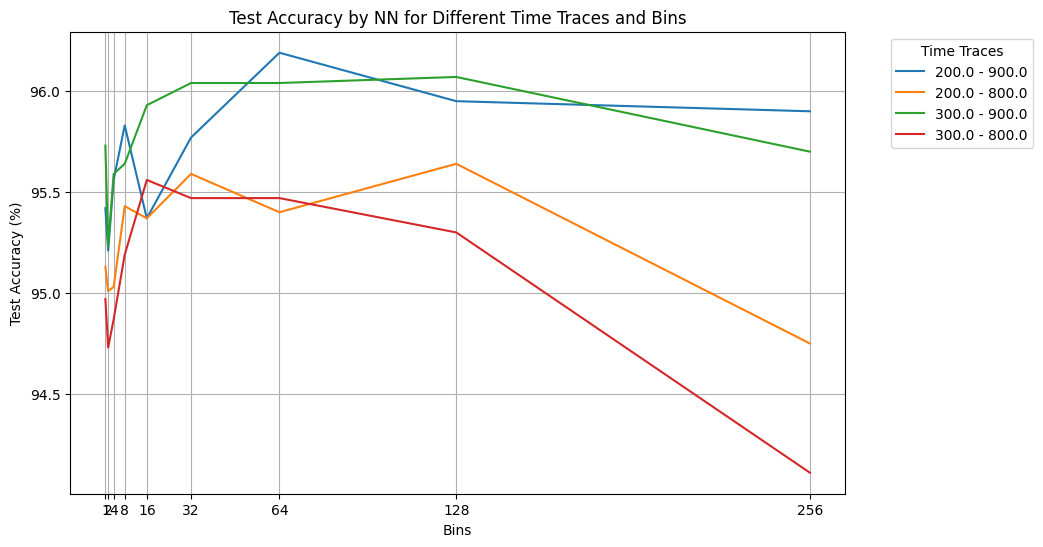

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON data
file_path = '20240826_exp2.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# Prepare the data for plotting
time_traces = list(data.keys())
bins = sorted([int(bin_key) for bin_key in data[time_traces[0]].keys()])

# Create a DataFrame to hold the accuracies
accuracy_data = {trace: [] for trace in time_traces}
for trace in time_traces:
    for bin_key in bins:
        accuracy = data[trace][str(bin_key)].split(' ')[2].replace('%', '')
        accuracy_data[trace].append(float(accuracy))

df = pd.DataFrame(accuracy_data, index=bins)

# Plot the table
plt.figure(figsize=(10, 6))
plt.plot(df)
plt.title('Test Accuracy by NN for Different Time Traces and Bins')
plt.xlabel('Bins')
plt.ylabel('Test Accuracy (%)')
plt.xticks(bins)
plt.legend(time_traces, title='Time Traces', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
